<a href="https://colab.research.google.com/github/achanhon/Lispchitz_penalty/blob/master/kolter_method/provable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### PREAMBLE
# Provable defenses against adversarial attacks
# Using ideas from linear programming and duality to create unbreakable, certified adversarial defenses
# Eric Wong
# header.svg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches

import PIL
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import torch
import torch.nn as nn

def to_image(X): 
    return X.data.permute(1,2,0)

def accuracy(X): 
    return (model(X).max(1)[1] == y).float().mean()

In [3]:
# random points at least 2r apart
m = 12
np.random.seed(3)
x = [np.random.uniform(size=(2))]
r = 0.16
while(len(x) < m):
    p = np.random.uniform(size=(2))
    if min(np.abs(p-a).sum() for a in x) > 2*r:
        x.append(p)
epsilon = r/2

x = np.array(x)
y = np.random.randint(0,2,m)



In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(4)

net = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,2)
)

opt = optim.Adam(net.parameters(), lr=1e-3)
for i in range(1000):
    out = net(torch.from_numpy(x).float())
    l = nn.CrossEntropyLoss()(out, torch.from_numpy(y))
    err = (out.max(1)[1].data != torch.from_numpy(y)).float().mean()
    if i % 100 == 0:
        print(f"Loss: {l.item():.2f}, Err: {err:.2f}")
    opt.zero_grad()
    (l).backward()
    opt.step()

Loss: 0.70, Err: 0.58
Loss: 0.59, Err: 0.42
Loss: 0.55, Err: 0.33
Loss: 0.49, Err: 0.33
Loss: 0.42, Err: 0.17
Loss: 0.36, Err: 0.08
Loss: 0.31, Err: 0.08
Loss: 0.26, Err: 0.00
Loss: 0.22, Err: 0.00
Loss: 0.18, Err: 0.00


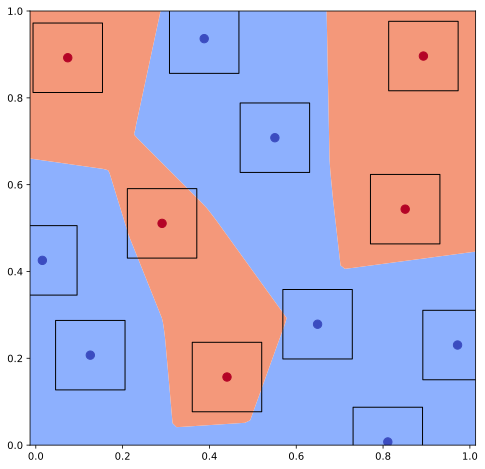

In [5]:
XX, YY = np.meshgrid(np.linspace(-0.1, 1.1, 100), np.linspace(0, 1, 100))
X0 = torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T)
y0 = net(X0)
ZZ = (y0[:,0] - y0[:,1]).view(100,100).data.numpy()

fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(x[:,0], x[:,1], c=y, cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0,1,0,1])

for a in x:
    ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))

# Part 3: Training a provably robust network

While the previous section showed a way to verify networks, it has two major shortcomings on real world problems. First, it is simply too loose to provide meaningful guarantees on standard networks. It is also expensive: even though it is not combinatorially expensive in runtime, solving a linear program is still not scalable to large networks, and is not very fast for use during training. However, in this section we will show that it is possible to compute a computationally tractable bound to the linear program. While this bound is inherently even more loose, we can counteract this with training by learning networks which minimize the bound, and get certified neural networks. 

In [ ]:
torch.manual_seed(4)

net = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,2)
)

opt = optim.Adam(net.parameters(), lr=1e-3)
X_pt, y_pt = torch.from_numpy(x).float(), torch.from_numpy(y)

W1, b1 = net[0].weight, net[0].bias
W2, b2 = net[2].weight, net[2].bias

We'll compute the upper and lower bounds for the ReLU activation using the same method as before, but now for PyTorch tensors. 

In [ ]:
def bounds_pt(X, net): 
    X2 = F.linear(X, W1, bias=b1)
    l,u = X2 - epsilon*W1.abs().sum(1), X2 + epsilon*W1.abs().sum(1)
    return torch.clamp(l,max=0), torch.clamp(u,min=0)

Next, we'll construct the dual network as a standard PyTorch module, which takes an input to the dual network $c$ along with the lower and upper bounds $(\ell,u)$. It's implemented using the transpose linear layers and the dual feasible solution for $\alpha$ as described earlier. 

In [ ]:
class DualNet(nn.Module): 
    def forward(self, c, l, u): 
        nu3 = -c
        nu2hat = F.linear(nu3, W2.t())
        nu2 = u/(u-l)*nu2hat
        nu1 = F.linear(nu2, W1.t())
        return (nu1,nu2,nu3)

dualnet = DualNet()

Given the dual network outputs $(\nu_1, \nu_2, \nu_3)$, and the lower bound $\ell$, we can create a function that computes the dual objective. To keep the code from being too verbose, we also use a helper function that performs the dot product of two vectors in batch mode called `bdot(X,Y)`. 

In [ ]:
def bdot(X,Y): 
    return torch.matmul(X.unsqueeze(-2),Y.unsqueeze(-1)).squeeze(-1).squeeze(-1)

def J(nu1, nu2, nu3, l): 
    return (- bdot(nu1, X_pt) - epsilon*nu1.abs().sum(-1)- bdot(nu2, b1) 
            + (l*torch.clamp(nu2,min=0)*I.float()).sum(-1) - bdot(nu3,b2))

Finally, we can put all these parts together and train against our bound on the worst case adversarial attack. Specifically, for each epoch, we first compute the lower and upper bounds of the ReLU activations. Then, we pass the corresponding vectors for each possible attack target through the dual network with the calculated lower and upper bounds. Finally, we compute the dual objective, drop it into the cross entropy loss function, and backpropagate. Note that the dual objective when $y = y^\text{target}$ is zero, and that we drop in the negative objective since we want to increase the certificate to become positive. 

In [ ]:
import torch.nn.functional as F
for i in range(5000):
    
    # Compute upper and lower bounds
    l,u = bounds_pt(X_pt, net)
    I = (u > 0)*(l < 0)
    
    # Pass through dual network
    c = torch.eye(2)[y_pt]*2-1
    nu1,nu2,n3 = dualnet(c,l,u)
    
    # Compute objective and loss
    dual_obj = J(nu1,nu2,nu3,l)
    loss = nn.CrossEntropyLoss()(-dual_obj.unsqueeze(-1)*(torch.eye(2)[~y]), y_pt)
    
    # Compute error and robust error
    out = net(torch.from_numpy(x).float())
    err = (out.max(1)[1].data != y_pt).float().mean()
    robust_err = (dual_obj < 0).float().mean()
    
    if i % 500 == 0:
        print(f"loss: {(loss).item():.2f}, err: {err.item():.2f}, robust err: {robust_err.item():.2f}")
    opt.zero_grad()
    (loss).backward()
    opt.step()

loss: 0.71, err: 0.58, robust err: 0.58
loss: 0.61, err: 0.17, robust err: 0.42
loss: 0.54, err: 0.17, robust err: 0.25
loss: 0.48, err: 0.17, robust err: 0.33
loss: 0.42, err: 0.00, robust err: 0.17
loss: 0.37, err: 0.00, robust err: 0.17
loss: 0.33, err: 0.00, robust err: 0.08
loss: 0.29, err: 0.00, robust err: 0.00
loss: 0.26, err: 0.00, robust err: 0.00
loss: 0.23, err: 0.00, robust err: 0.00


We can also compute some statistics, namely the loss of the dual objective, the standard error rate, and the robust error rate.  The robust error rate is the the fraction of examples which are not certified (so the dual objective is negative), which provides an upper bound on the worst case adversarial attack. In other words, the robust error is a guarantee that our model cannot be attacked to worse than the robust error rate. Since the network eventually achieves a 0% robust error rate, every example in the dataset is guaranteed to be safe against adversarial attacks. 

Finally, let's once again visualize the classifier that we have learned. In contrast to the standard network, we now see that all the squares representing the perturbation regions are now fully contained in either the red or the blue classes. This is to be expected, since the network was able to certify every point in the dataset. 

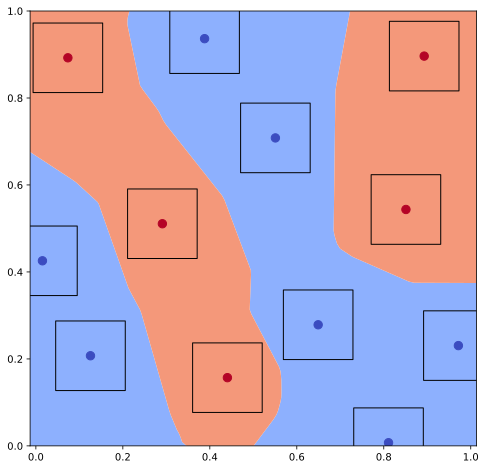

In [ ]:
y0 = net(X0)
ZZ = (y0[:,0] - y0[:,1]).view(100,100).data.numpy()

fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(x[:,0], x[:,1], c=y, cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0,1,0,1])

for a in x:
    ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))

## Computing upper and lower bounds via the dual network

Finally, within this framework there is a straightforward, inductive way to compute upper and lower bounds for the ReLU activations: we can write the problem of finding lower and upper bounds for each ReLU activation in almost the same way as the adversarial problem with two differences. First, we only use a subset of the network up to the activation in question, and second, we use a different adversarial objective. For example, we can write the problem of finding a lower bound to an activation in the $k$th layer as 

$$\begin{split}
\min_{z} \;\;&z_k^Te_i\\
\textrm{subject to}\;\;  z_{i+1} &= W_i z_i + b_i\;\; \text{for}\;\;i=1...k-1\\
z_i &= \max(\hat z_i, 0) \;\; \text{for}\;\; i=2\dots k-1\\
\epsilon &\geq \|z_1  - x\|_\infty 
\end{split}$$

Note that this is structurally identical to the problem of finding an adversarial example on a $k$ layer network, but with the objective $z_k^Te_i$ instead of $z_k^T(y - y^\text{target})$. In other words, the "adversary" is trying to minimize the output of the $i$th activation at the $k$th layer. As a result, the entire framework can apply towards calculating lower and upper bounds, by passing in $\pm e_i$ through a subset of the dual network and calculating the same dual objective, which gives lower and upper bounds for the $i$th activation in the $k$th layer. In fact, by caching intermediate results, it is possible to compute upper and lower bounds for all activations with a single pass through the dual network. For more details, see Algorithm 1 of the [main paper](https://arxiv.org/abs/1711.00851). 

# Summary

In this post, we showed how to derive provable bounds on all possible adversarial attacks within the $\ell_\infty$ threat model. We started by formulating the adversary as a non-convex optimization problem. We then bounded the adversary with an easier linear program, and bounded it again with a dual feasible solution. Finally, by training against the dual objective, the lower bound becomes large enough to actually guarantee safety. 


## Further reading

1. For more on this method, we have written two papers on this topic. The main paper [[Wong & Kolter, 2018]](https://arxiv.org/abs/1711.00851) contains results for HAR, MNIST, Fashion-MNIST, and SVHN. The follow-up paper [[Wong et al., 2018]](https://arxiv.org/abs/1805.12514) provides a generalization of this work to arbitrary computational graphs using conjugate functions, and scales it to larger networks  with random projections, obtaining results on CIFAR10. All code and models for these two papers can be found at our Github repository [here](https://github.com/locuslab/convex_adversarial), along with a pip installable package called `convex_adversarial`. 

2. While in this work we used an LP relaxation of the network architecture, another approach is to use an SDP type relaxation [[Raghunathan et al. 2018a]](https://arxiv.org/abs/1801.09344) and train against an SDP-based bound. Although SDP-based methods have some difficulty scaling up to larger networks, it is able to achieve robustness in a complementary manner to our dual LP relaxation: our bound is vacuous on the SDP-trained network, and the SDP bound is vacuous on the LP-trained network. However, their follow-up work on expanding SDP verification to networks with multiple hidden layers is less particular to the specific training method and able to get tighter bounds on networks [[Raghanuathan et al. 2018b]](https://arxiv.org/abs/1811.01057), though cannot be used during training. 

3. Bounding the adversarial problem has since then been approached by a multitude of perspectives. For example, one can use abstract interpretations and zonotopes to come up with bounds on the adversarial output of a network [[Gehr et al., 2018]](https://www.cs.rice.edu/~sc40/pubs/ai2.pdf), which has also been applied towards training [[Mirman et al., 2018]](http://proceedings.mlr.press/v80/mirman18b.html), and expanded upon several times [[Singh et al., 2018]](https://eth-sri.github.io/publications/singh2018effective) [[Singh et al., 2019]](https://eth-sri.github.io/publications/singh2019domain). Other work has approached the verification problem directly in the primal space, propagating bounds forward through the network with methods called FastLin [[Weng et al., 2018]](https://arxiv.org/abs/1804.09699), Crown [[Zhang et al., 2018]](https://arxiv.org/pdf/1811.00866.pdf), and Neurify [[Wang et al., 2018]](https://arxiv.org/pdf/1809.08098.pdf). However, all these methods end up being virtually identical to the algorithm presented in this blog post, and a more formal comparison describing the equivalences of all these LP-based methods was recently released [[Salman et al., 2019]](https://arxiv.org/pdf/1902.08722.pdf). 

4. Propagating interval bounds forward through the network, when carefully implemented, can actually be quite effective at achieving competitive, state of the art performance [[Gowal et al., 2018]](https://arxiv.org/abs/1810.12715). 

5. Hope is not lost yet for heuristic defenses! With the release of the MIP solver by [[Tjeng et al., 2018]](https://arxiv.org/abs/1711.07356), some heuristic defenses can now be verified with exact solvers using ideas like ReLU stability [[Xiao et al., 2018]](https://arxiv.org/abs/1809.03008) or maximization of linear regions [[Croce et al., 2018]](https://arxiv.org/abs/1810.07481) [(GitHub link)](https://github.com/max-andr/provable-robustness-max-linear-regions). 

6. Recent work out of LocusLab: randomized smoothing can now be used to create high probability certificates for $\ell_2$-norm bounded perturbations on ImageNet classifiers, albeit at the cost of drawing many samples for a good Monte-Carlo estimate [[Cohen et al., 2019]](https://arxiv.org/abs/1902.02918). 

7. For a broader introduction to adversarial examples, Zico Kolter and Aleksander Madry presented a tutorial on adversarial examples at NeurIPS 2018, which is available online [here](https://adversarial-ml-tutorial.org/). 